# Download and install libraries

In [1]:
# !pip install --user mediapipe
# !pip install --user git+https://github.com/sign-language-processing/datasets.git

In [2]:
# !wget "https://raw.githubusercontent.com/davidlainesv/TSSI-WLASL100/test/skeleton_graph.py"

# Load data

In [3]:
import tensorflow_datasets as tfds
import sign_language_datasets.datasets
from sign_language_datasets.datasets.config import SignDatasetConfig
import itertools

2023-03-09 00:46:45.509768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 00:46:45.763482: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-09 00:46:48.868328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-09 00:46:48.868459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

In [4]:
config = SignDatasetConfig(name="only-poses",
                           version="1.0.0",
                           include_video=False,
                           include_pose="holistic",
                           fps=30)
autsl, info = tfds.load(name='autsl', data_dir="datasets", builder_kwargs={"config": config}, with_info=True)

2023-03-09 00:46:52.331983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jupyter/.local/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-09 00:46:52.332025: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-09 00:46:52.332076: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-10-20230307-192439): /proc/driver/nvidia/version does not exist
2023-03-09 00:46:52.332502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in othe

In [5]:
autsl.keys()

dict_keys(['test', 'train', 'validation'])

In [6]:
ds_train = autsl["train"]
ds_validation = autsl["validation"]
ds_test = autsl["test"]

for datum in itertools.islice(ds_train, 0, 3):
  print(
      datum['id'].numpy().decode('utf-8'),
      datum['pose']['data'].shape,
      datum['gloss_id'].numpy())

signer21_sample22 (58, 1, 543, 4) 194
signer8_sample1334 (67, 1, 543, 4) 10
signer3_sample171 (57, 1, 543, 4) 116


In [7]:
info.features

FeaturesDict({
    'gloss_id': int32,
    'id': Text(shape=(), dtype=string),
    'meaning': FeaturesDict({
        'english': Text(shape=(), dtype=string),
        'turkish': Text(shape=(), dtype=string),
    }),
    'pose': PoseFeature({'data': TensorInfo(shape=(None, 1, 543, 4), dtype=float32), 'conf': TensorInfo(shape=(None, 1, 543), dtype=float32), 'fps': TensorInfo(shape=(), dtype=int32)}),
    'sample': int32,
    'signer': int32,
})

# Preprocess data and save

In [8]:
import tensorflow as tf
from autsl_preprocessing import Preprocessing
from skeleton_graph import tssi_v2

tssi_order = tssi_v2()[1]
pp = Preprocessing(tssi_order)

def fn_map(example):
    example["pose"] = pp(example["pose"]["data"])
    return example

ds_train_mapped = ds_train.map(fn_map, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
ds_validation_mapped = ds_validation.map(fn_map, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
ds_test_mapped = ds_test.map(fn_map, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

for datum in itertools.islice(ds_train_mapped, 0, 3):
  print(
      datum['id'].numpy().decode('utf-8'),
      datum['pose'].shape,
      datum['gloss_id'].numpy())

signer38_sample320 (66, 135, 3) 129
signer21_sample22 (58, 135, 3) 194
signer10_sample509 (40, 135, 3) 128


In [9]:
import numpy as np

features_dict_updated = dict(info.features)
features_dict_updated['pose'] = tfds.features.Tensor(shape=(None, len(tssi_order), 3), dtype=np.float32)
features_dict_updated

{'id': Text(shape=(), dtype=string),
 'signer': Tensor(shape=(), dtype=int32),
 'sample': Tensor(shape=(), dtype=int32),
 'gloss_id': Tensor(shape=(), dtype=int32),
 'meaning': FeaturesDict({
     'english': Text(shape=(), dtype=string),
     'turkish': Text(shape=(), dtype=string),
 }),
 'pose': Tensor(shape=(None, 135, 3), dtype=float32)}

In [10]:
!rm -r "datasets/autsl_tssi"

In [11]:
# Optionally define a custom `data_dir`.
# If None, then the default data dir is used.
custom_data_dir = "datasets"

# Define the builder.
tfds.dataset_builders.store_as_tfds_dataset(
    name="autsl_tssi",
    version="1.0.0",
    data_dir=custom_data_dir,
    split_datasets={
        "train": ds_train_mapped,
        "validation": ds_validation_mapped,
        "test": ds_test_mapped,
    },
    features=tfds.features.FeaturesDict(features_dict_updated),
    description="AUTSL dataset in TSSI v2 format",
    release_notes={
        "1.0.0": "Initial release!",
    }
)


Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling datasets/autsl_tssi/1.0.0.incompleteZFXU02/autsl_tssi-train.tfrecord*...:   0%|          | 0/28142 […

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling datasets/autsl_tssi/1.0.0.incompleteZFXU02/autsl_tssi-validation.tfrecord*...:   0%|          | 0/44…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling datasets/autsl_tssi/1.0.0.incompleteZFXU02/autsl_tssi-test.tfrecord*...:   0%|          | 0/3742 [00…

Dataset autsl_tssi downloaded and prepared to datasets/autsl_tssi/1.0.0. Subsequent calls will reuse this data.


# See results

In [12]:
autsl_tssi, info = tfds.load(name='autsl_tssi', data_dir="datasets", with_info=True)

In [13]:
autsl_tssi.keys()

dict_keys(['train', 'validation', 'test'])

In [14]:
ds_train_tssi = autsl_tssi["train"]
ds_validation_tssi = autsl_tssi["validation"]
ds_test_tssi = autsl_tssi["test"]

for datum in itertools.islice(ds_train_tssi, 0, 3):
  print(
      datum['id'].numpy().decode('utf-8'),
      datum['pose'].shape,
      datum['gloss_id'].numpy())

signer12_sample160 (70, 135, 3) 59
signer8_sample1194 (57, 135, 3) 163
signer0_sample556 (42, 135, 3) 39


In [15]:
ds_train_tssi.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=28142>

In [16]:
ds_validation_tssi.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=4418>

In [17]:
ds_test_tssi.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=3742>

In [18]:
import pandas as pd

entries = []
for example in ds_train_tssi:
    arr = example["pose"].numpy()[:, :, 0]
    entry = {"min": arr.min(), "max": arr.max()}
    entries.append(entry)

pd.DataFrame(entries).describe()

,min,max
count,28142.000000,28142.000000
mean,0.002279,0.738267
std,0.028167,0.068187
min,-0.146304,0.562849
25%,0.000000,0.696016
50%,0.000000,0.727037
75%,0.000000,0.770323
max,0.449125,1.206354


In [19]:
import pandas as pd

entries = []
for example in ds_train_tssi:
    arr = example["pose"].numpy()[:, :, 1]
    entry = {"min": arr.min(), "max": arr.max()}
    entries.append(entry)

pd.DataFrame(entries).describe()

,min,max
count,28142.000000,28142.000000
mean,0.002126,0.862701
std,0.026309,0.107339
min,-0.054593,0.613519
25%,0.000000,0.780849
50%,0.000000,0.870554
75%,0.000000,0.939791
max,0.430540,1.178494


In [20]:
import pandas as pd

entries = []
for example in ds_train_tssi:
    arr = example["pose"].numpy()[:, :, 2]
    entry = {"min": arr.min(), "max": arr.max()}
    entries.append(entry)

pd.DataFrame(entries).describe()

,min,max
count,28142.000000,28142.000000
mean,0.000051,0.861160
std,0.003126,0.072155
min,0.000000,0.584314
25%,0.000000,0.815686
50%,0.000000,0.866667
75%,0.000000,0.909804
max,0.368627,1.000000


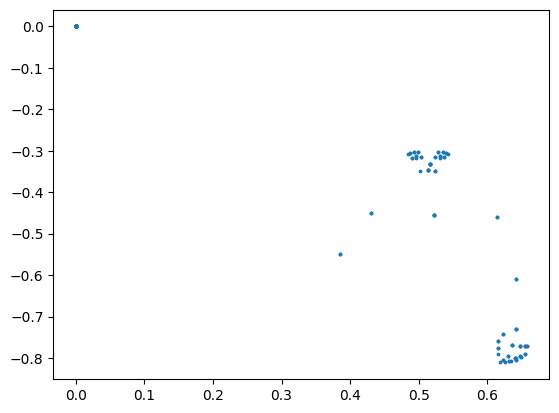

In [27]:
import matplotlib.pyplot as plt

xdata = example["pose"][20, :, 0]
ydata = example["pose"][20, :, 1]

plt.scatter(xdata, -ydata, s=3)